Data shape: (33, 5)
Cross-validated R²: -1.204 ± 1.523

Model RMSE: 1.51 MPa
Rebound Hammer RMSE: 4.44 MPa


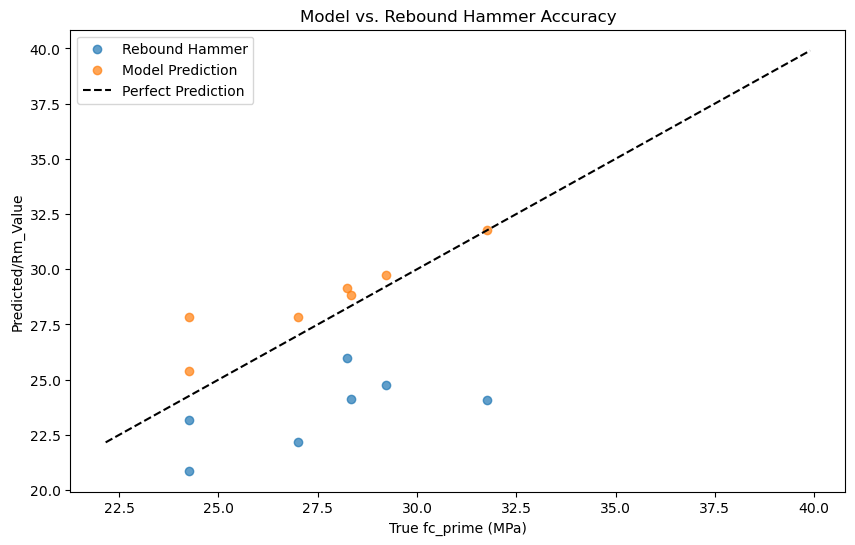


Feature Importance:
          Feature  Importance
0        Rm_Value    0.570273
3           RCA_%    0.233286
4           WTA_%    0.196441
1  Cement (kg/m3)    0.000000
2      FA (kg/m3)    0.000000

Predicted Strength: 33.81 MPa


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# ======================
# 1. Load and Prepare Data
# ======================
df = pd.read_excel('block data.xlsx')

# Average by Block_ID (to avoid data leakage)
df_avg = df.groupby(['Mix_ID', 'Block_ID']).mean(numeric_only=True).reset_index()

# Define inputs (Rm_Value + mixture proportions) and target (true strength)
X = df_avg[['Rm_Value', 'Cement (kg/m3)', 'FA (kg/m3)', 'RCA_%', 'WTA_%']]
y = df_avg['fc_prime (MPa)']

print(f"Data shape: {X.shape}")  # Verify (e.g., (36, 5))

# ======================
# 2. Train-Test Split
# ======================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ======================
# 3. Model Training (Random Forest)
# ======================
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Cross-validation (to check stability)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-validated R²: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

# ======================
# 4. Evaluate Model vs. Rm_Value
# ======================
y_pred = model.predict(X_test)

# Compare model predictions vs. Rm_Value vs. True fc_prime
results = pd.DataFrame({
    'True_fc': y_test,
    'Model_Prediction': y_pred,
    'Rm_Value': X_test['Rm_Value']
})

# Calculate errors
model_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rm_rmse = np.sqrt(mean_squared_error(y_test, X_test['Rm_Value']))

print(f"\nModel RMSE: {model_rmse:.2f} MPa")
print(f"Rebound Hammer RMSE: {rm_rmse:.2f} MPa")

# Plot comparison
plt.figure(figsize=(10, 6))
plt.scatter(y_test, X_test['Rm_Value'], label='Rebound Hammer', alpha=0.7)
plt.scatter(y_test, y_pred, label='Model Prediction', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='Perfect Prediction')
plt.xlabel('True fc_prime (MPa)')
plt.ylabel('Predicted/Rm_Value')
plt.title('Model vs. Rebound Hammer Accuracy')
plt.legend()
plt.show()

# ======================
# 5. Feature Importance
# ======================
importances = model.feature_importances_
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}) \
               .sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

# ======================
# 6. Prediction Example
# ======================
new_mix = pd.DataFrame({
    'Rm_Value': [30],          # Rebound hammer reading
    'Cement (kg/m3)': [350],   # Mixture proportions
    'FA (kg/m3)': [700],
    'RCA_%': [30],
    'WTA_%': [10]
})

predicted_strength = model.predict(new_mix)[0]
print(f"\nPredicted Strength: {predicted_strength:.2f} MPa")